In [ ]:
import os
import re
import json
import uuid
import operator
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from IPython.display import Image, display
from typing import Annotated, TypedDict, Annotated, Tuple, Union, TypedDict, Sequence
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage , BaseMessage, trim_messages
from langchain.embeddings import init_embeddings
from langchain.chat_models import init_chat_model
from langchain.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph, MessagesState

In [2]:
load_dotenv(override=True)

True

In [3]:
THREAD = os.getenv('THREAD')
USER_ID = os.getenv('USER_ID')
GRAPH_PATH = os.getenv('GRAPH_PATH')
BASE_URL = os.getenv('BASE_URL')
OPENAI_CHAT_MODEL = os.getenv('OPENAI_CHAT_MODEL')
OPENAI_EMBED_MODEL = os.getenv('OPENAI_EMBED_MODEL')
OPENAI_API_PROXY = os.getenv('OPENAI_API_PROXY')

In [4]:
CONFIG = {'configurable': {'thread_id': THREAD, 'recursion_limit': 3, "user_id": USER_ID}}

In [5]:
langsmith_api = os.getenv("LANGSMITH_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agent Two"

In [7]:
with open(GRAPH_PATH, "r") as f:
    data = json.load(f)

In [8]:
llm = init_chat_model(api_key = OPENAI_API_PROXY, base_url = BASE_URL, model = OPENAI_CHAT_MODEL)

In [ ]:
embeddings = init_embeddings(api_key = OPENAI_API_PROXY, base_url = BASE_URL, model = OPENAI_EMBED_MODEL)

In [10]:
memory = MemorySaver()

In [11]:
store = InMemoryStore(index = {"embed": embeddings,"dims": 1536, "fields": ["memory", "type"]})

In [12]:
class PlanExecute(TypedDict):
    input: str
    plan: list[str]
    past_steps: Annotated[list[Tuple], operator.add]
    lo: str
    conclusion: str

In [13]:
class Step(BaseModel):
    title: str = Field(..., description="A concise title for the step.")
    description: str = Field(..., description="A detailed description of the step.")
    learning_objective: str = Field(..., description="The learning objective.")

In [14]:
class Plan(BaseModel):
    steps: list[Step] = Field(..., description="A list of steps in sequential order.")

In [15]:
class LearningObject(BaseModel):
    title: str = Field(..., description="A concise title.")
    content: str = Field(..., description="The actual learning content.")

In [16]:
class Conclusion(BaseModel):
    conclusion: str = Field(..., description="A concise summary of the key aspects.")

In [17]:
class Act(BaseModel):
    action: Union[Conclusion, Plan] = Field(..., description=("Choose an action: "
                                                              "- Conclusion if you want to finalize. "
                                                              "- Plan if you need more steps."))

In [18]:
class LearningSession(BaseModel):
    """Provide a topic for a learning session"""
    input: str = Field(..., description="A topic / concept for the learning session and The learning objective of the session.")

In [542]:
planner_ = """
You are a Learning Experience Designer for Machine Learning.
Create plan (Intro & Main Parts) for educational content delivery.
Structure content logically with clear progression between concepts.
"""

learner_ = """
You are a Machine Learning Learning Experience Designer.
Create a learning object with:
- Title: Concise description (max 10 words)
- Content: Educational material with brief intro building to main content
"""

replaner_ = planner_ +  """
You are a Learning Experience Designer for Machine Learning.

Topic: {input}
Plan: {plan}
Completed Step: {past_steps}

Take one action:
a. If both plan steps are completed: Provide a succinct conclusion summarizing key points
b. Otherwise: Return only the remaining step (do not repeat completed steps)
"""

In [543]:
planner_prompt = ChatPromptTemplate.from_messages([("system", planner_),("placeholder", "{messages}")])
planner = planner_prompt | llm.with_structured_output(Plan)

In [544]:
learning_prompt = ChatPromptTemplate.from_messages([("system", learner_), ("placeholder", "{messages}")])
object = learning_prompt | llm.with_structured_output(LearningObject)

In [545]:
replanner_prompt = ChatPromptTemplate.from_template(replaner_)
replanner = replanner_prompt | llm.with_structured_output(Act)

In [546]:
def profile(config = CONFIG, store = store):
    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "profile")
    profile_types = {"name": "Name", "interests": "Interests", "preferences": "Preferences", "goals": "Goals"}

    profile_lines = [
        f"{label}: {' '.join(m.value['memory'] for m in store.search(namespace, filter={'type': p_type}, limit=5))}"
        for p_type, label in profile_types.items()
    ]
    user_profile = "\n".join(profile_lines)
    
    return user_profile

In [547]:
def store_profile(content: str, profile_type: str,  config = CONFIG, store = store):
    """Stores a user profile attribute in the database.
    
    Args:
        content (str): The value of the profile attribute to store
        profile_type (str): The category or type of the profile attribute. Valid types include: "name", "interests", "preferences", "goals".

    Returns:
        str: A confirmation message indicating the successfully stored content and its unique identifier (UUID).
    
    Raises:
        ValueError: If an invalid `profile_type` is provided.  
    """
    VALID_PROFILE_TYPES = {"name", "interests", "preferences", "goals"}

    if profile_type not in VALID_PROFILE_TYPES:
        raise ValueError(
            f"Invalid profile_type: '{profile_type}'. Valid types are: {', '.join(VALID_PROFILE_TYPES)}."
        )

    user_id = config.get("configurable", {}).get("user_id")
    if not user_id:
        raise ValueError("User ID not found in configuration.")

    namespace = (user_id, "profile")
    memory_id = str(uuid.uuid4())
    
    store.put(
        namespace,
        key=memory_id,
        value={"memory": content, "type": profile_type},
        index=False
    )
    
    return f"Stored information: '{content}' | ID: {memory_id}"

In [27]:
store_profile("John", "name")
store_profile("Machine Learnign, Physics", "interests")
store_profile("Simple examples, Fun Facts", "preferences")
store_profile("Learn Basic Sataisitcs, Apply it in ML, Become Data Scientist", "goals")

print(profile())

Name: John
Interests: Machine Learnign, Physics
Preferences: Simple examples, Fun Facts
Goals: Learn Basic Sataisitcs, Apply it in ML, Become Data Scientist


In [ ]:
def execute_step(state: PlanExecute):
    plan = state["plan"]
    current_step = plan[0]
    plan_str = "\n".join(
        f"{i+1}. {step.title}\nDescription: {step.description}\nLearning Objective: {step.learning_objective}\n"
        for i, step in enumerate(plan))
    
    user_info = profile()

    personalize = f"""
            Personalize the learning experience for the user using the following profile information:

            User Profile: {user_info}

            **Instructions for Personalization:**

            1. **Address by Name:** If the user's name is provided, use it to create a more personal and engaging interaction. If it's not the first response, do not use a greeting.
            2. **Goal Alignment:**  Directly relate the content of the current step to the user's stated learning goals. Explain how understanding this step will help them reach their goals. Acknowledge how previous learning steps have built a foundation for the current step. Avoid repeating information previously covered.
            3. **Learning Style Adaptations:** Modify the presentation style based on the user's learning preferences (e.g., if they prefer visual, include visual elements, if they prefer examples, provide lots of concrete examples).
            4. **Interest Integration:** If possible, tie the examples or explanations to the user's interests.
            5. **Flexibility:** If not all information is available, create the best personalization possible based on what is present.
            6. **Progression and Flow:** The current content should build upon the previous steps' content instead of restarting the lesson or definition. Use transitional language to create a smoother progression between steps.
            7. **Output Format:** The output must be a clear, concise and build up from the previous output.

            NOTE: DO NOT mention user's profile. 
            """

    if state["past_steps"]:
        previous_steps_str = ". ".join([f'{i+1}. {desc}' for i, desc in enumerate(state["past_steps"])])
        prompt = f"""Given this overall learning plan:\n{plan_str}\n
                     And, having already covered: {previous_steps_str}\n
                     Your task is to execute step: {current_step}, building on previous information and anticipating future steps. 
                     Focus on clear explanations, avoid repeating previous points and ensure a smooth flow of learning."""
    else:
        prompt = f"""Given this learning plan:\n{plan_str}\n
                     Your task is to execute step: {current_step}, focusing on clear explanations and anticipating future steps."""

    result = object.invoke({"messages": [("user", prompt + personalize)]})
    return {"past_steps": [current_step], "lo": result}

def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    return {"conclusion": output.action.conclusion} if isinstance(output.action, Conclusion) else {"plan": output.action.steps}

def disclose(state: PlanExecute):
    return Command(goto="replan") if interrupt({"llm_output": state["lo"]}) else Command(goto=END)

def should_end(state: PlanExecute):
    return END if state.get("conclusion") else "learning_object"

In [29]:
learningflow = StateGraph(PlanExecute)

learningflow.add_node("planner", plan_step)
learningflow.add_node("learning_object", execute_step)
learningflow.add_node("replan", replan_step)
learningflow.add_node("disclosure", disclose)

learningflow.add_edge(START, "planner")
learningflow.add_edge("planner", "learning_object")
learningflow.add_edge("learning_object", "disclosure")
learningflow.add_edge("disclosure", "replan")

learningflow.add_conditional_edges("replan", should_end, ["learning_object", END])

learn = learningflow.compile(checkpointer = memory)

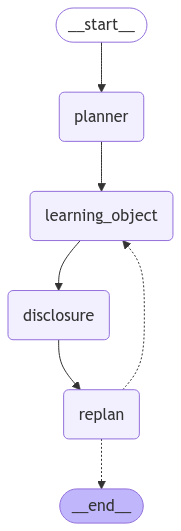

In [30]:
learn

In [30]:
class EvalExecute(TypedDict):
    input: str
    evaluations: list[str]
    past_evals: Annotated[list[Tuple], operator.add]
    eo: str
    answer: Annotated[list[Tuple], operator.add]
    report: str    

In [31]:
class Eval(BaseModel):
    title: str = Field(..., description = "A concise title for the evaluation.")
    description: str = Field(..., description = "A detailed description of the evaluation's content or purpose.")

In [32]:
class Evaluations(BaseModel):
    evals: list[Eval] = Field(..., description = "A list of evaluations, in sequential order.")

In [33]:
class EvalObject(BaseModel):
    title: str = Field(..., description = "Concise title of the evaluation object.")
    content: str = Field(..., description = "The actual content of the evaluation object (questoon, multiple choice, code, etc.).")
    evaluation_criteria: list[str] = Field(..., description="List of criteria that the generated question should evaluate e.g. knowledge of x, y, z.")

In [34]:
class Report(BaseModel):
    report: str = Field(..., description = "A concise summary of the main points of the completed evaluation.")

In [35]:
class ActE(BaseModel):
    action: Union[Report, Evaluations] = Field(..., description = "Action to perform. "
                                                               "- If you want to conclude, use Report. "
                                                               "- If you need to progress further, use Evaluations.")

In [36]:
class AssessmentSession(BaseModel):
    """Determine skills for a assessment session"""
    input: str

In [37]:
# sub eval:
mapper_ = """
    You are an expert psychometrician tasked with designing a comprehensive evaluation strategy. 
    Your goal is to create a structured list of assessment methods and activities that effectively gauge knowledge acquisition, directly aligned with a previously executed Learning Session Content. 
    This list will serve as a guide for instructors to organize their evaluation process.

    Avoid referencing specific evals from the Learning Session Content.
    Focus on outlining the high-level structure of the evaluation, rather than providing detailed, moment-by-moment instructions.
    Each evaluation should be laser-focused on assessing a single, specific concept. Refrain from combining multiple concepts within a single assessment activity.

    Key Guidelines:

        - The evaluation plan should be structured logically, with clear progression between evals.
        - Do not include any preamble or summary in your response.
        - Limit to 3 evals.
    """

In [38]:

assessor_ = """
    You are an expert psychometrician tasked with creating focused evaluation items. 
    Your objective is to generate a single 'EvalObject' that delivers clear and precise assessment content, concentrating on a single concept at a time.

    Key Guidelines:

        -   The 'title' should be a concise and descriptive title (maximum 10 words) for the specific evaluation focus.
        -   The 'content' should provide a single, well-structured assessment item (e.g., a question, multiple-choice problem, code snippet, etc.) related to the target concept.
        -   The 'evaluation_criteria' should specify a single, clear criterion that the assessment item is designed to evaluate.
        -   Do not include any preamble or summary in your response.
        -   Focus on one specific concept per 'EvalObject'.
    """

In [39]:
remaper_ = mapper_ + """

        Learning Session Content: {input}

        Original Evaluations List: {evaluations}

        Completed Evals: {past_evals}

    If all the Evaluations of the Original Evaluations List are in Completed Evals and you can provide a report to the learner, do so.  
    Otherwise, update the Evaluations with ONLY the remaining Evals, providing the same level of detail as before.   
    Do not repeat previously completed evaluations.
        """

In [40]:
mapper = ChatPromptTemplate.from_messages([("system", mapper_),("placeholder", "{messages}")]) | llm.with_structured_output(Evaluations)

In [41]:
assessment = ChatPromptTemplate.from_messages([("system", assessor_), ("placeholder", "{messages}")]) | llm.with_structured_output(EvalObject)

In [42]:
remapper = ChatPromptTemplate.from_template(remaper_) | llm.with_structured_output(ActE)

In [43]:
def execute_eval(state: EvalExecute):
    evaluations = state["evaluations"]
    current_eval = evaluations[0]
    eval_str = "\n".join(f"{i+1}. {eval}" for i, eval in enumerate(evaluations, start=1))
    prompt = f"For the following evaluation plan:\n{eval_str}\n\nYou are tasked with executing evaluation {1}: {current_eval}"
    result = assessment.invoke({"messages": [("user", prompt)]})
    return {"past_evals": [current_eval], "eo": result}

def plan_eval(state: EvalExecute):
    evaluations = mapper.invoke({"messages": [("user", {"input": state["input"]})]})
    return {"evaluations": evaluations.evals}

def remap_eval(state: EvalExecute):
    output = remapper.invoke(state)
    return {"report": output.action.report + str(state['past_evals']) + str(state['answer'])} if isinstance(output.action, Report) else {"evaluations": output.action.evals}

def assess(state: EvalExecute):
    answer = interrupt("Please provide your answer: ")
    return {"answer": [answer]}

def should_end(state: EvalExecute):
    return END if state.get("report") else "evaluation_object"


In [44]:
evaluationflow = StateGraph(EvalExecute)

evaluationflow.add_node("mapper", plan_eval)
evaluationflow.add_node("evaluation_object", execute_eval)
evaluationflow.add_node("remap", remap_eval)
evaluationflow.add_node("assessment", assess)

evaluationflow.add_edge(START, "mapper")
evaluationflow.add_edge("mapper", "evaluation_object")
evaluationflow.add_edge("evaluation_object", "assessment")
evaluationflow.add_edge("assessment", "remap")

evaluationflow.add_conditional_edges("remap", should_end, ["evaluation_object", END])

evaluate = evaluationflow.compile(checkpointer = memory)

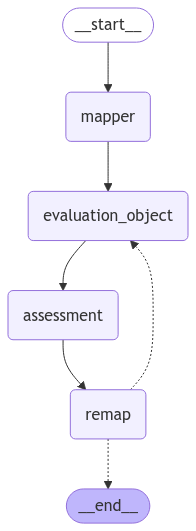

In [46]:
evaluate

### Tools:

In [45]:
@tool
def store_profile(content: str, profile_type: str,  config = CONFIG, store = store):
    """Stores a user profile attribute in the database.
    
    Args:
        content (str): The value of the profile attribute to store
        profile_type (str): The category or type of the profile attribute.  
                            Valid types include: "name", "interests", "preferences", "goals".

    Returns:
        str: A confirmation message indicating the successfully stored content and its unique identifier (UUID).
    
    Raises:
        ValueError: If an invalid `profile_type` is provided.  
    """
    VALID_PROFILE_TYPES = {"name", "interests", "preferences", "goals"}


    if profile_type not in VALID_PROFILE_TYPES:
        raise ValueError(
            f"Invalid profile_type: '{profile_type}'. Valid types are: {', '.join(VALID_PROFILE_TYPES)}."
        )

    user_id = config.get("configurable", {}).get("user_id")
    if not user_id:
        raise ValueError("User ID not found in configuration.")

    namespace = (user_id, "profile")
    memory_id = str(uuid.uuid4())
    
    store.put(
        namespace,
        key=memory_id,
        value={"memory": content, "type": profile_type},
        index=False
    )
    
    return f"Stored information: '{content}' | ID: {memory_id}"

In [46]:
@tool
def retrieve_profile(profile_type: str, config = CONFIG, store = store):
    """Retrieves user profile information of a specified type.

    Args:
        profile_type: The type of information to retrieve ("name", "interests", "preferences", "goals").

    Returns:
        list: A list of dictionaries, each with 'content' and 'id'.  Empty list if no match.

    Raises:
        ValueError: For invalid profile_type.
    """

    VALID_PROFILE_TYPES = {"name", "interests", "preferences", "goals"}

    if profile_type not in VALID_PROFILE_TYPES:
        raise ValueError(
            f"Invalid profile_type: '{profile_type}'. Valid types are: {', '.join(VALID_PROFILE_TYPES)}."
        )

    user_id = config.get("configurable", {}).get("user_id")
    if not user_id:
        raise ValueError("User ID not found in configuration.")

    namespace = (user_id, "profile")
    results = store.search(namespace, filter={"type": profile_type})
    
    return [
        {"content": item.value.get("memory", ""), "id": item.key}
        for item in results
    ]

In [47]:
@tool
def delete_profile(key: str, config = CONFIG, store = store):
    """Deletes a specific user profile entry by its ID.

    Args:
        key: The unique ID of the profile entry to delete.

    Returns:
        str: A confirmation message if deleted or an error message if not found.
    """
    user_id = config.get("configurable", {}).get("user_id")
    if not user_id:
        return "Error: User ID not found in configuration."

    namespace = (user_id, "profile")
    
    try:
        success = store.delete(namespace, key)
        if success:
            return f"Profile entry with ID {key} has been successfully deleted."
        else:
            return f"Error: No profile entry found with ID {key}."
    except Exception as e:
        return f"An error occurred while deleting the profile entry: {str(e)}"

In [48]:
@tool
def retrieve_sections(section_letter: str, data: dict = data):
    """Retrieves a list of concepts belonging to a specific section.

    Args:
        section_letter: The letter of the section to retrieve concepts from (e.g., "A", "B").

    Returns:
        A list of dictionaries, where each dictionary represents a concept and contains:
            - "id": The unique ID of the concept.
            - "label": The name or label of the concept.  
        Returns an empty list if no concepts are found for the given section.
        Returns an error message if input is invalid.
    """
    if data is None:
        return "Error: 'data' dictionary not provided."  #Handle missing data
    if not isinstance(section_letter, str) or not section_letter.isalpha() or len(section_letter) != 1:
        return "Error: Invalid section letter.  Must be a single alphabet character."
    if "concepts" not in data:
        return "Error: 'concepts' key not found in the data dictionary."

    results = []
    for concept_id, concept_info in data["concepts"].items():
        if concept_info["section"] == section_letter:
            results.append({"id": concept_id, "label": concept_info["label"]})
    return results

In [49]:
@tool
def retrieve_concept(concept_id: str, data: dict = data):
    """Retrieves a concept by its unique ID.

    Args:
        concept_id: The ID of the concept to retrieve.

    Returns:
        A dictionary containing the concept's information if found, otherwise returns None.  
        The concept dictionary, if found, will typically contain keys like "label", "section", and other relevant details.
        Returns an error message if input is invalid.
    """
    if data is None:
        return "Error: 'data' dictionary not provided." #Handle missing data
    if not isinstance(concept_id, str):
        return "Error: Invalid concept ID. Must be a string."
    if "concepts" not in data:
        return "Error: 'concepts' key not found in the data dictionary."

    return data["concepts"].get(concept_id, None)

In [50]:
@tool
def update_concept_status(concept_id: str, new_status: str, path: str = GRAPH_PATH):
    """
    Updates a concept's status in a JSON file and saves the changes.

    Args:
        concept_id (str): The ID of the concept to update. Must follow the format 'Letter.Number' (e.g., 'A.1').
        new_status (str): The new status for the concept. Must be one of "mastery", "unlearned", or "awareness".

    Returns:
        str: A message indicating success or failure, including details of any errors.
    """

    ALLOWED_STATUSES = {"mastery", "unlearned", "awareness"}
    CONCEPT_ID_PATTERN = re.compile(r'^[A-Z]\.\d+$')

    if not isinstance(concept_id, str):
        return "Error: Invalid concept ID type. Must be a string."
    if not CONCEPT_ID_PATTERN.match(concept_id):
        return ("Error: Invalid concept ID format. "
                "The correct format is a single uppercase letter followed by a dot and a number (e.g., 'A.1').")
    if not isinstance(new_status, str):
        return "Error: Invalid status type. Must be a string."

    if new_status not in ALLOWED_STATUSES:
        allowed = ", ".join(sorted(ALLOWED_STATUSES))
        return f"Error: Invalid status '{new_status}'. Allowed statuses are: {allowed}."
    if not os.path.exists(path):
        return f"Error: File '{path}' does not exist."
    try:
        with open(path, "r") as f:
            data = json.load(f)
    except json.JSONDecodeError as jde:
        return f"Error reading JSON from '{path}': {jde}"
    except Exception as e:
        return f"Error opening '{path}': {e}"
    if "concepts" not in data:
        return "Error: 'concepts' key not found in the JSON data."
    if concept_id in data["concepts"]:
        current_status = data["concepts"][concept_id].get("status", "undefined")
        if current_status == new_status:
            return f"No update needed: Concept '{concept_id}' is already set to '{new_status}'."
        data["concepts"][concept_id]["status"] = new_status
        try:
            with open(path, "w") as f:
                json.dump(data, f, indent=4)
            return (f"Success: Status of concept '{concept_id}' updated from "
                    f"'{current_status}' to '{new_status}'.")
        except Exception as e:
            return f"Error saving changes to '{path}': {e}"
    else:
        return f"Error: Concept with ID '{concept_id}' not found."

In [51]:
def knowledge_state(path: str = GRAPH_PATH):
    """
    Retrieves all concepts that have a non-empty status and returns them in a readable format.

    Args:
        path (str): The file path to the JSON data. Defaults to GRAPH_PATH.

    Returns:
        str: A formatted string listing concepts with non-empty statuses or an error message.
    """
    if not os.path.exists(path):
        return f"Error: File '{path}' does not exist."
    try:
        with open(path, "r") as f:
            data = json.load(f)
    except json.JSONDecodeError as jde:
        return f"Error reading JSON from '{path}': {jde}"
    except Exception as e:
        return f"Error opening '{path}': {e}"
    if "concepts" not in data:
        return "Error: 'concepts' key not found in the JSON data."

    concepts_with_status = [
        {
            "ID": cid,
            "Label": details.get("label", "N/A"),
            "Status": details.get("status", "N/A")
        }
        for cid, details in data["concepts"].items()
        if details.get("status")
    ]

    if not concepts_with_status:
        return "No concepts with a non-empty status found."

    concepts_with_status.sort(key=lambda x: x["ID"])

    formatted_lines = [
        f"{c['ID']} {c['Label']} is {c['Status']}"
        for c in concepts_with_status
    ]

    formatted_output = "\n".join(formatted_lines)
    return formatted_output

In [52]:
@tool
def get_prerequisites(concept_id: str, path: str = GRAPH_PATH):
    """
    Retrieves all prerequisites for a given concept ID, including their IDs and labels.

    Args:
        concept_id (str): The ID of the concept whose prerequisites are to be retrieved.

    Returns:
        str: A formatted string of prerequisites or an error message.
    """
    CONCEPT_ID_PATTERN = r'^[A-Za-z]+\.\d+$'

    if not re.match(CONCEPT_ID_PATTERN, concept_id):
        return (f"Error: Invalid concept ID format '{concept_id}'. "
                "The correct format should be letters followed by a dot and number, e.g., 'A.1'.")

    if not os.path.exists(path):
        return f"Error: File '{path}' does not exist."

    try:
        with open(path, "r") as f:
            data = json.load(f)
    except json.JSONDecodeError as jde:
        return f"Error reading JSON from '{path}': {jde}"
    except Exception as e:
        return f"Error opening '{path}': {e}"

    if "concepts" not in data:
        return "Error: 'concepts' key not found in the JSON data."

    if concept_id not in data["concepts"]:
        return f"Error: Concept with ID '{concept_id}' not found."

    prerequisites_ids = data["concepts"][concept_id].get("prerequisites", [])

    if not prerequisites_ids:
        return f"Concept '{concept_id}' has no prerequisites."

    prerequisites = []
    missing_prereqs = []
    for pid in prerequisites_ids:
        prereq = data["concepts"].get(pid)
        if prereq:
            prerequisites.append({"ID": pid, "Label": prereq.get("label", "N/A")})
        else:
            missing_prereqs.append(pid)

    output_lines = [f"Prerequisites for Concept '{concept_id}':"]

    for prereq in prerequisites:
        output_lines.append(f" - {prereq['ID']}: {prereq['Label']}")

    if missing_prereqs:
        output_lines.append("\nWarning: The following prerequisite IDs were not found in the data:")
        for pid in missing_prereqs:
            output_lines.append(f" - {pid}")

    return "\n".join(output_lines)

In [53]:
knowledge_space = (
    "* Section A (A.1 – A.4): Measures of Central Tendency. \n"
    "* Section B (B.1 – B.5): Measures of Spread & Dispersion. \n"
    "* Section C (C.1 – C.5): Probability Fundamentals & Distributions. \n"
    "* Section D (D.1 – D.7): Statistical Inference, Sampling, and Testing. \n"
    "* Section E (E.1 – E.3): Correlation & Regression."
)

persona = (
    "You are a Learning Experience Designer (LXD) specializing in personalized learning paths. \n"
    "Your task is to curate relevant learning content for users based on their individual profiles and knowledge state."
)

task = (
    "Based on user's profile and current knowledge state, recommend the most relevant next learning concept from the Knowledge Graph. \n"
    "Explain your reasoning for selecting this concept, considering user's interests, learning preferences, and goals."
    "Knowledge graph is to guide your decision on elarning path direction. And make decison on what to present to the user via Learning Session."
    "You can engage LearningSession, during learnign session user will be exposed to the step-by-step learning session."
    "At the end of the session you will receive the a summary of the learnig content covered during the session."
)

instruction = (
    "Prioritize New Information: Always use the most up-to-date user information. \n"
    "If there's a conflict, discard the old data and use the new data. \n"
    "Uniqueness: Ensure there are no duplicate entries in the user profile. \n"
    "No Context: Do not provide any additional context or explanation beyond the requested concept ID and reasoning."
    "NEVER use plain text for mathematical symbols. \n"
    "NEVER use parentheses ( ) for variables - use LaTeX notation instead. \n"
    "IMPORTANT: Use math notation by enclosing them in double dollar signs / block math."
)

guidelines = (
    "Personalization: Tailor your reasoning to user's learning preferences by using encouraging and supportive language. \n"
    "Learning Path: Consider the logical progression of concepts within the knowledge graph. \n"
    "Recommend a concept that builds upon user's existing knowledge (represented by knowledge_state). \n"
)

In [58]:
def prepare_messages(state, config=CONFIG, store=store):
    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "profile")
    profile_types = {"name": "Name", "interests": "Interests", "preferences": "Preferences", "goals": "Goals"}

    profile_lines = [
        f"* {label}: {' '.join(m.value['memory'] for m in store.search(namespace, filter={'type': p_type}, limit=5))}"
        for p_type, label in profile_types.items()
    ]
    user_profile = "\n".join(profile_lines)
    
    return [{
        "role": "system",
        "content": (
            f"**PERSONA:**\n{persona}\n\n"
            f"**USER PROFILE:**\n{user_profile}\n\n"
            f"**KNOWLEDGE GRAPH STRUCTURE:**\n{knowledge_space}\n\n"
            f"**KNOWLEDGE STATE:**\n{knowledge_state()}\n\n"
            f"**TASK:**\n{task}\n\n"
            f"**INSTRUCTIONS:**\n{instruction}\n\n"
            f"**GUIDELINES:**\n{guidelines}\n\n"
        )
    }] + state["messages"]

In [59]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    lesson: str

class LearningSession(BaseModel):
    """Provide a topic for a learnign session"""
    input: str

class AssessmentSession(BaseModel):
    """Determine skills for a assessment session"""
    input: str

In [60]:
tools = [store_profile, retrieve_profile, delete_profile, retrieve_sections, retrieve_concept, get_prerequisites, update_concept_status]

In [61]:
tool_node = ToolNode(tools)

In [ ]:
model = llm.bind_tools(tools + [LearningSession] + [AssessmentSession])

In [63]:
tools_by_name = {tool.name: tool for tool in tools}

In [64]:
def call_model(state: AgentState, config: RunnableConfig):
    messages = trim_messages(state['messages'], strategy = "last",token_counter = len,max_tokens = 15,start_on = "human",end_on = ("human", "tool"),include_system = True)
    system_prompt = SystemMessage(prepare_messages({"messages": []})[0]["content"])
    response = model.invoke([system_prompt] + messages, config)
    return {"messages": [response]}

def learn_loop(state: AgentState):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    topic = state["messages"][-1]
    response = learn.invoke({"input": json.loads(topic.additional_kwargs['tool_calls'][0]['function']['arguments'])["input"]})
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": response}]
    return {"messages": tool_message, "lesson": response}

def eval_loop(state: AgentState):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    print(state["lesson"]['lo'].content)
    topic = state["lesson"]['lo'].content
    response = evaluate.invoke({"input": {"messages": [{"role": "user", "content": topic}]}})
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": response}]
    return {"messages": tool_message}

def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]

    if not last_message.tool_calls:
        return END
    elif last_message.tool_calls[0]["name"] == "LearningSession":
        return "learning session"
    elif last_message.tool_calls[0]["name"] == "AssessmentSession":
        return "evaluation session"
    else:
        return "action"

In [65]:
mainflow = StateGraph(MessagesState)

mainflow.add_node("agent", call_model)
mainflow.add_node("action", tool_node)
mainflow.add_node("learning session", learn_loop)
mainflow.add_node("evaluation session", eval_loop)

mainflow.add_edge(START, "agent")
mainflow.add_conditional_edges("agent", should_continue)
mainflow.add_edge("action", "agent")
mainflow.add_edge("learning session", "agent")
mainflow.add_edge("evaluation session", "agent")

main = mainflow.compile(checkpointer = memory)

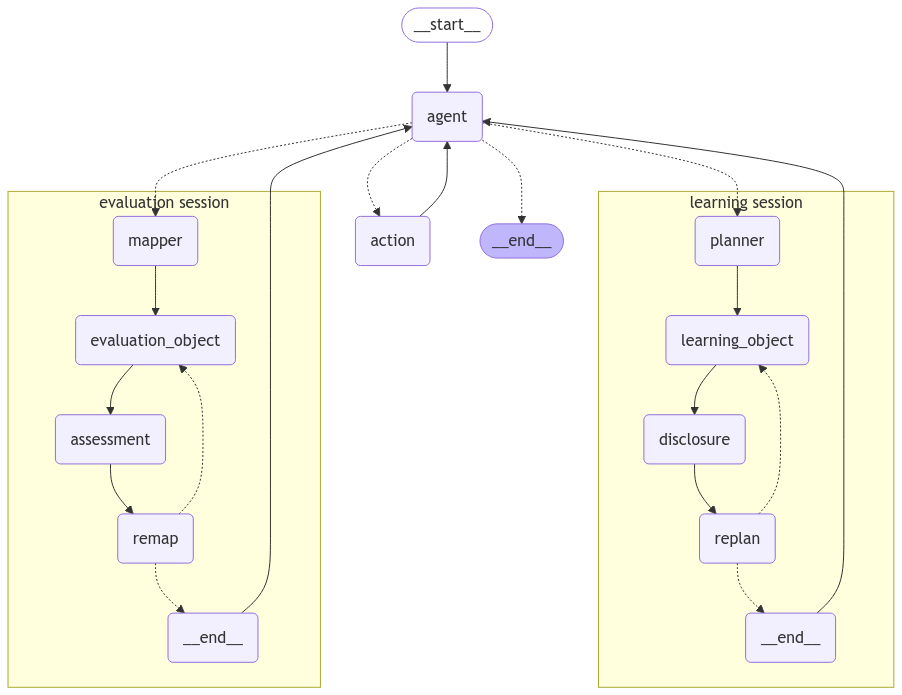

In [64]:
display(Image(main.get_graph(xray=2).draw_mermaid_png()))

### Tests:

In [66]:
def invoke_llm(input_string, main=main, config=CONFIG):
    state = main.get_state(config)
    payload = {"messages": [{"role": "user", "content": input_string}]}

    if state.next in [('learning session',), ('evaluation session',)]:
        command = Command(resume=input_string)
        response = main.invoke(command, config=config, subgraphs=True)
    elif not state.next:
        response = main.invoke(payload, config=config, subgraphs=True)
    else:
        raise ValueError(f"Unexpected state.next value: {state.next}")

    response_content = "No valid content found in the response."
    
    response_data = response[1] if len(response) > 1 and isinstance(response[1], dict) else {}

    if 'messages' in response_data and isinstance(response_data['messages'], list) and response_data['messages']:
        last_message = response_data['messages'][-1]
        response_content = getattr(last_message, 'content', response_content)
    elif 'lo' in response_data:
        response_content = getattr(response_data['lo'], 'content', response_content)
    elif 'eo' in response_data:
        response_content = getattr(response_data['eo'], 'content', response_content)

    return response_content, response 

In [67]:
response, _ = invoke_llm('What shall we start with?')
response

'Probability is a fundamental concept in both statistics and machine learning, as it helps in predicting future occurrences and making informed decisions. A probability space forms the basis of understanding this concept. It consists of three elements: a sample space (S), events (E), and a probability function (P). The sample space is the set of all possible outcomes. For instance, in a coin toss, S = {Heads, Tails}. An event is a subset of the sample space; here, E could be {Heads} or {Tails}.\n\nProbability axioms are foundational rules used to calculate probabilities. They state that: \n1. The probability of an event is always between 0 and 1 (inclusive).\n2. The probability of the entire sample space S is 1.\n3. If two events are mutually exclusive, the probability of either event occurring is the sum of their probabilities.\n\nTo illustrate, consider the toss of a fair coin. The probability (P) of landing on heads is 0.5. These basic rules and examples align with statistical model

In [68]:
response, _ = invoke_llm('Sure, Lets do it!')
response

'Probability distributions are central to understanding patterns in data. Let\'s delve into discrete and continuous distributions, which you\'ve briefly touched upon with the foundational concepts of probability.\n\n**Discrete Distributions**: These involve finite or countably infinite outcomes. For instance, the **binomial distribution** models the number of successes in a fixed number of independent Bernoulli trials. Imagine a simple machine learning algorithm predicting whether an email is spam or not over 10 trials. The binomial distribution can help determine the probability of observing any number of "spam" predictions.\n\n**Continuous Distributions**: These cover outcomes over a continuum. A basic example is the **normal distribution**, familiar in physics as it describes numerous phenomena like measurement errors. It\'s a key player in machine learning, underpinning many algorithms that assume a normal distribution of input features.\n\nUse these distributions to calculate **me

In [69]:
for i, item in enumerate(_[1]['plan'], start=1):
    print(f"\n{i}. {item.title.upper()}")
    print("-")
    print(f"{item.description}")
    print("-")
    print(f"{item.learning_objective}")


1. EXPLORATION OF PROBABILITY DISTRIBUTIONS
-
Building on the foundational concepts, students will explore different types of probability distributions. Explain the difference between discrete and continuous distributions, and introduce common distributions like the binomial and normal distributions. Use visual aids and practical examples to show how these distributions are used to model real-world phenomena. Students will learn to interpret the characteristics of each distribution, such as mean, variance, and standard deviation.
-
Identify and understand key probability distributions, including their properties and applications. Recognize the difference between discrete and continuous distributions.


In [70]:
_

(('learning session:2cf1a26a-0e68-a526-57ea-8134949f24a6',),
 {'input': 'C.1 Probability Fundamentals & Distributions',
  'plan': [Step(title='Exploration of Probability Distributions', description='Building on the foundational concepts, students will explore different types of probability distributions. Explain the difference between discrete and continuous distributions, and introduce common distributions like the binomial and normal distributions. Use visual aids and practical examples to show how these distributions are used to model real-world phenomena. Students will learn to interpret the characteristics of each distribution, such as mean, variance, and standard deviation.', learning_objective='Identify and understand key probability distributions, including their properties and applications. Recognize the difference between discrete and continuous distributions.')],
  'past_steps': [Step(title='Introduction to Probability Fundamentals', description='In this initial step, studen